<a href="https://colab.research.google.com/github/ayulockin/deepimageinpainting/blob/master/Image_Inpainting_Autoencoder_Decoder_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando TensorFlow e checando se a GPU responde a ele

In [16]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

print('[INFO]', tf.config.experimental.list_physical_devices('GPU')[0])

2.10.1
[INFO] PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [17]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid


' \n\nbiblioteca do autor para salvar log, TODO : estudar isso \n\nimport wandb\nfrom wandb.keras import WandbCallback\n\nwandb.login()\n\n'

## Carregando o dataset, pré-processando e criando o dataset de treino e teste

In [1]:
import os
from keras.preprocessing.image import ImageDataGenerator

# Definir diretórios base
base_dir = 'ImageNet100k'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Criar geradores de imagem
datagen = ImageDataGenerator(rescale=1./255)  # Normalizar os valores dos pixels para [0,1]

# Carregar as imagens dos diretórios
train_generator = datagen.flow_from_directory(train_dir, target_size=(256, 256), batch_size=32, class_mode=None, shuffle=True)
val_generator = datagen.flow_from_directory(val_dir, target_size=(256, 256), batch_size=32, class_mode=None, shuffle=False)
test_generator = datagen.flow_from_directory(test_dir, target_size=(256, 256), batch_size=32, class_mode=None, shuffle=False)

# Para obter os tamanhos dos conjuntos
print('Tamanho do conjunto de treino:', train_generator.samples)
print('Tamanho do conjunto de validação:', val_generator.samples)
print('Tamanho do conjunto de teste:', test_generator.samples)

FileNotFoundError: [Errno 2] No such file or directory: 'ImageNet100k/train'

### Analisando amostras do dataset

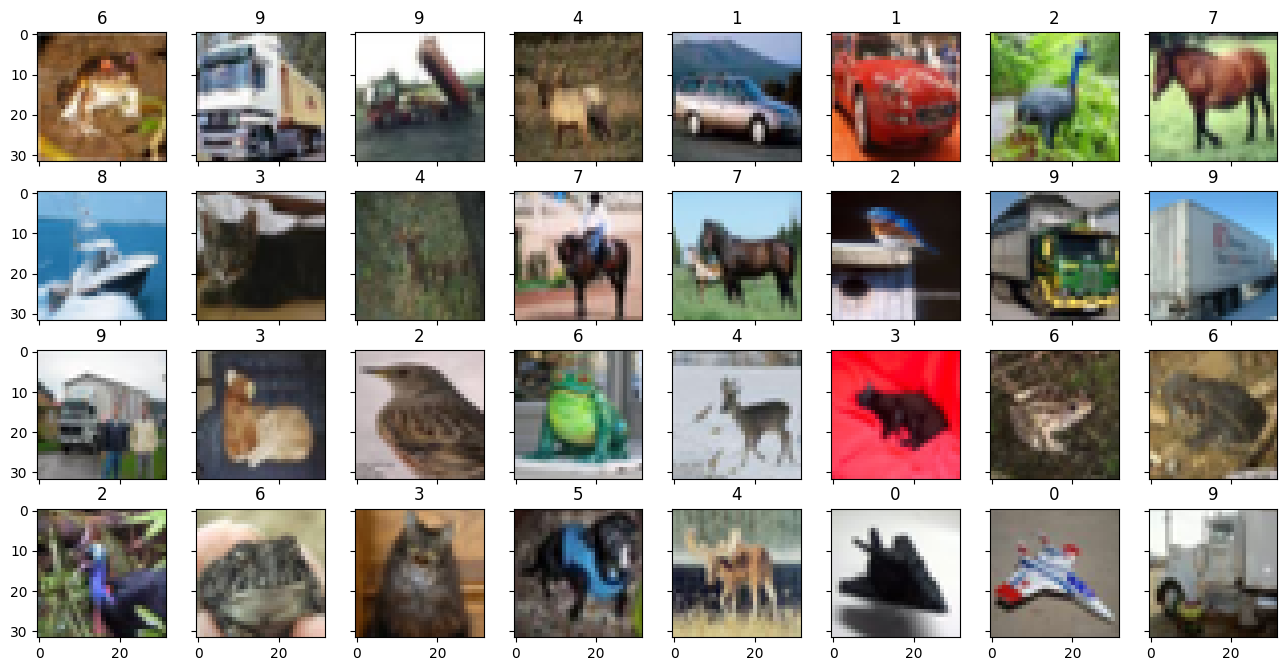

In [19]:
sample_images = x_train[:32]
sample_labels = y_train[:32]

# cria uma grade de figuras que sâo samples do conjunto de treino ( as 32 primeiras imagens )

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 8), axes_pad=0.3,)

for ax, image, label in zip(grid, sample_images, sample_labels):
  ax.imshow(image)
  ax.set_title(label[0])

plt.show()

#### Data Generator with Patch Augmentation

In [35]:
## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

## Seguindo a referência acima, criamos uma classe para gerar os dados de treino e teste, é um gerador de dados que além de tudo 
## aplica uma máscara aleatória nas imagens de treino, para que a rede aprenda a reconstruir a imagem original a partir da máscara.

class createAugment(keras.utils.Sequence):
    """
    Classe dedicada para data Augmentation, em especial para o problema de inpainting, criando máscaras.
    """
    def __init__(self, X, y, batch_size=32, dim=(32, 32), n_channels=3, shuffle=True):
        'Initialization'
        self.batch_size = batch_size 
        self.X = X 
        self.y = y
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        
        self.on_epoch_end() # Inicializa os índices assim que o objeto é criado

    def on_epoch_end(self) -> None:
        """
        Inicializa ou re-inicializa os indexes após cada época, de preferencia com shuffle = True para o modelo desempenhar de forma robusta.
        """
        self.indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self) -> int:
        """
        Retorna o número de batches por época
        """
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index) -> tuple:
        """
        É passado um batch de índices para o gerador de dados, que retorna um batch de dados gerados a partir dos índices passados.
        """
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        return self.__data_generation(indexes)

    def __data_generation(self, idxs) -> tuple:
        """ 
        Função que gera um batch de dados para treinamento a partir de um batch de índices. Os dados retornados são um batch de imagens
        mascaradas e um batch de imagens originais, para que o erro seja calculado a partir da imagem reconstruída.
        """

        # Cria matrizes que serâo retornadas, com o tamanho adequado mas sem valores por enquanto.
        X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Imagem mascarada
        y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Imagem original

        for i, idx in enumerate(idxs):
            image_copy = self.X[idx].copy()

            # Cria uma imagem mascarada a partir do método __createMask
            masked_image = self.__createMask(image_copy)
            
            X_batch[i,] = masked_image/255
            y_batch[i] = self.y[idx]/255
            
        return X_batch, y_batch

    def __createMask(self, img):
        ## Prepare masking matrix
        mask = np.full((32,32,3), 255, np.uint8)
        
        # Número de rabiscos a serem feitos
        for _ in range(np.random.randint(2, 7)):
            # Número de pontos no rabisco
            num_points = np.random.randint(2, 8)
            
            # Gera pontos aleatórios
            points = np.random.randint(1, 32, (num_points, 2))
            
            # Get random thickness of the scribble
            thickness = np.random.randint(1, 2)
            
            # Draw the scribble on the mask
            cv2.polylines(mask, [points], isClosed=False, color=(1,1,1), thickness=thickness)

        # Perforn bitwise and operation to mask the image
        masked_image = cv2.bitwise_and(img, mask)

        return masked_image


In [36]:
# Preparando geradores de dados para treino e teste
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_test, x_test, shuffle=False)

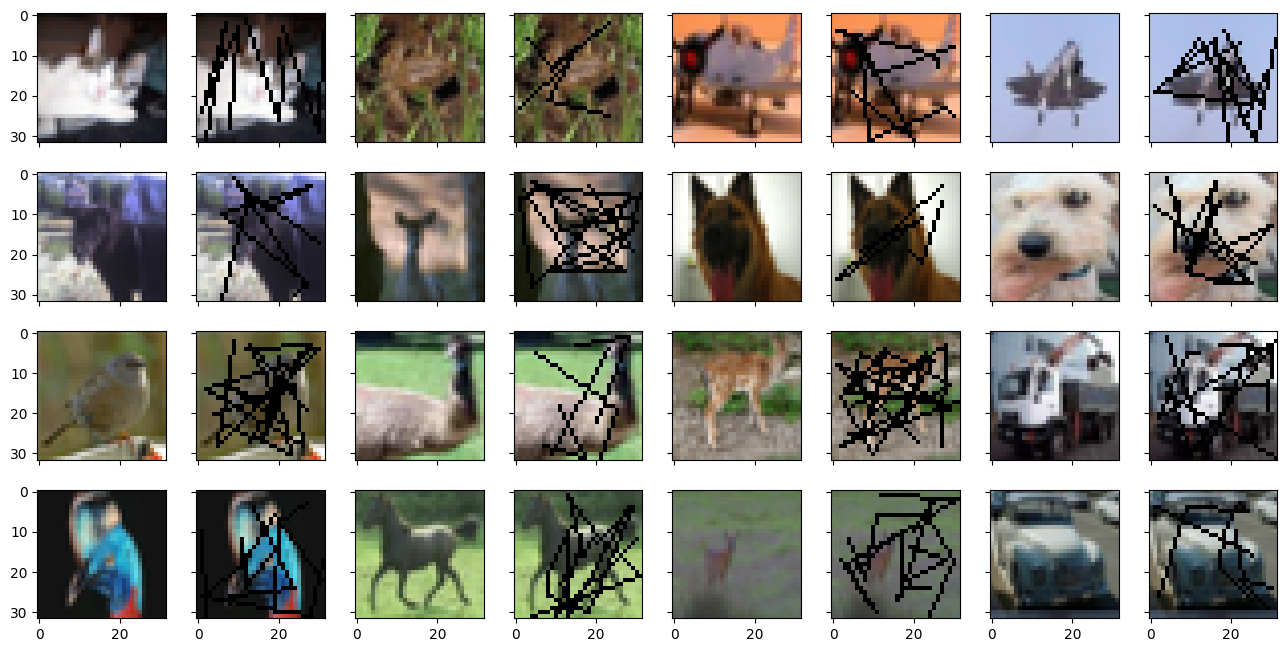

In [37]:
## Examples
sample_idx = 90 ## Change this to see different batches

sample_masks, sample_labels = traingen[sample_idx]
sample_images = [None]*(len(sample_masks)+len(sample_labels))
sample_images[::2] = sample_labels
sample_images[1::2] = sample_masks

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

## Autoencoder-Decoder Model

In [38]:
# Vídeo sobre a métrica do coeficiente de dice que vamos usar: https://www.youtube.com/watch?v=AZr64OxshLo
# Essa métrica é basicamente uma medida de o quanto essa imagem se parece com a original, ou seja, o quanto a imagem reconstruída
# se parece com a imagem original.
# Quanto mais próximo de 1, melhor.

def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [39]:
class inpaintingModel:
  '''
  Fazendo uma UNET para o problema de inpainting. 
  '''
  def prepare_model(self, input_size=(32,32,3)):
    inputs = keras.layers.Input(input_size)

    conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs) 
    conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
    conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 
    
    conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
    conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)
    
    conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)
    
    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

    return keras.models.Model(inputs=[inputs], outputs=[outputs])  

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up

In [40]:
keras.backend.clear_session()
model = inpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])

# é a figura do modelo mas n ta rodando pq precisa baixar uma dependencia
keras.utils.plot_model(model, show_shapes=True, dpi=76, to_file='model_v1.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Train

In [43]:
_ = model.fit(traingen, 
          workers = 1,
          use_multiprocessing = False,
          validation_data=testgen, 
          epochs=20, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen))

Epoch 1/20
1562/1562 [==============================] - 58s 37ms/step - loss: 0.0198 - dice_coef: 0.6032 - val_loss: 0.0199 - val_dice_coef: 0.6010
Epoch 2/20
1562/1562 [==============================] - 59s 38ms/step - loss: 0.0171 - dice_coef: 0.6037 - val_loss: 0.0161 - val_dice_coef: 0.6033
Epoch 3/20
1562/1562 [==============================] - 58s 37ms/step - loss: 0.0160 - dice_coef: 0.6039 - val_loss: 0.0140 - val_dice_coef: 0.6050
Epoch 4/20
1562/1562 [==============================] - 59s 38ms/step - loss: 0.0152 - dice_coef: 0.6042 - val_loss: 0.0144 - val_dice_coef: 0.6095
Epoch 5/20
1562/1562 [==============================] - 58s 37ms/step - loss: 0.0143 - dice_coef: 0.6043 - val_loss: 0.0129 - val_dice_coef: 0.6043
Epoch 6/20
1562/1562 [==============================] - 58s 37ms/step - loss: 0.0140 - dice_coef: 0.6043 - val_loss: 0.0167 - val_dice_coef: 0.6011
Epoch 7/20
1562/1562 [==============================] - 58s 37ms/step - loss: 0.0135 - dice_coef: 0.6044 - val_l

# Testing on images

1/1 [==============================] - 0s 21ms/step


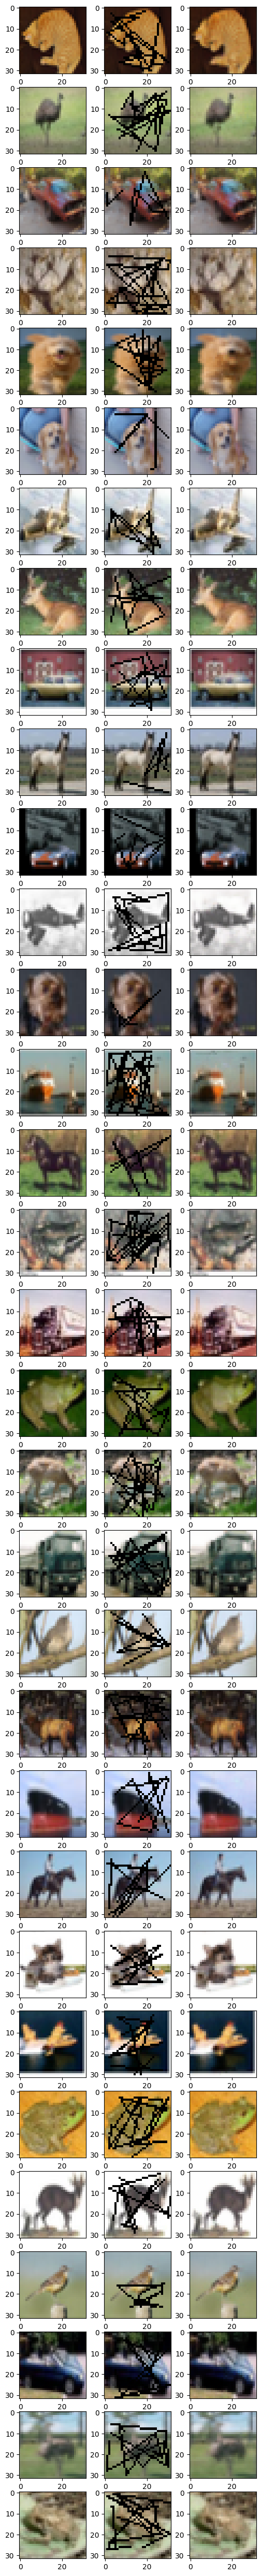

In [44]:
# Exemplos teste
rows = 32
sample_idx = 54
sample_images, sample_labels = traingen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 2*rows))

for i in range(32):
  impainted_image = model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))
  axs[i][0].imshow(sample_labels[i])
  axs[i][1].imshow(sample_images[i])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))

plt.show()